In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.4.1


### Data Pre-Processing

In [2]:
base_dir = r"C:\Users\pothi\OneDrive\Desktop\DSIP\Dataset\Alzheimer_s Dataset"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'ModerateDemented', 'NonDemented', 'MildDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


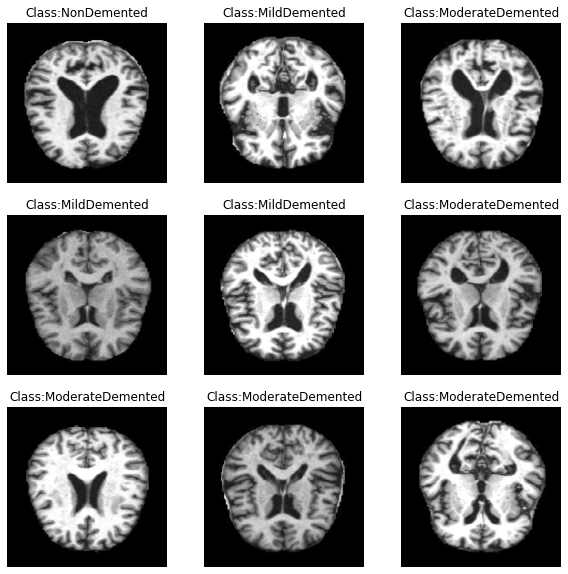

In [5]:
def show_images(generator,y_pred=None):

    labels =dict(zip([0,1,2,3], CLASSES))

    x,y = generator.next()
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
show_images(train_data_gen)

In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [8]:

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [9]:

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [10]:

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import  BatchNormalization, GlobalAveragePooling2D

densenet_model = DenseNet121(input_shape=(176, 176, 3), include_top=False, weights="imagenet")


29089792/29084464 [==============================] - 0s 0us/step


In [11]:
# Freeze layers in the base model
for layer in densenet_model.layers:
    layer.trainable = False

In [12]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
custom_densenet_model = Sequential([
    densenet_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4, activation='softmax')        
], name="densenet_cnn_model")


In [14]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

custom_densenet_model.compile(optimizer='rmsprop',loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)

custom_densenet_model.summary()

Model: "densenet_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 5, 5, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)        

In [15]:
EPOCHS = 100
history = custom_densenet_model.fit(train_data, train_labels,validation_data=(val_data, val_labels),callbacks=CALLBACKS,epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 28s 66ms/step - loss: 1.5738 - acc: 0.3323 - auc: 0.5994 - f1_score: 0.3288 - val_loss: 0.7559 - val_acc: 0.6523 - val_auc: 0.8981 - val_f1_score: 0.6451
Epoch 2/100
256/256 [==============================] - 13s 52ms/step - loss: 0.9115 - acc: 0.5969 - auc: 0.8509 - f1_score: 0.5881 - val_loss: 0.6213 - val_acc: 0.7007 - val_auc: 0.9274 - val_f1_score: 0.6965
Epoch 3/100
256/256 [==============================] - 13s 52ms/step - loss: 0.7754 - acc: 0.6568 - auc: 0.8930 - f1_score: 0.6555 - val_loss: 0.5599 - val_acc: 0.7490 - val_auc: 0.9423 - val_f1_score: 0.7468
Epoch 4/100
256/256 [==============================] - 13s 52ms/step - loss: 0.7001 - acc: 0.6964 - auc: 0.9119 - f1_score: 0.6939 - val_loss: 0.5243 - val_acc: 0.7661 - val_auc: 0.9501 - val_f1_score: 0.7632
Epoch 5/100
256/256 [==============================] - 13s 52ms/step - loss: 0.6460 - acc: 0.7314 - auc: 0.9266 - f1_score: 0.7313 - val_loss: 0.5114 - val_acc: 0.7

### Tabulating the Results of our custom DenseNet121 model

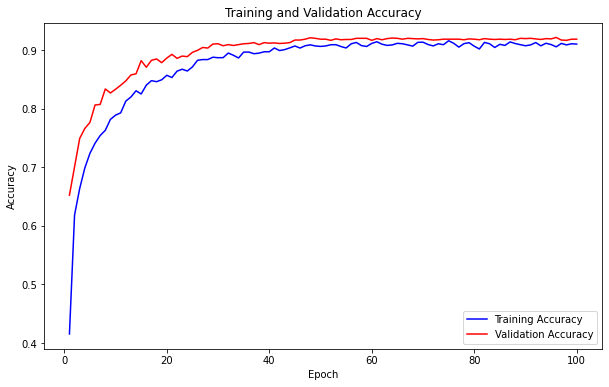

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


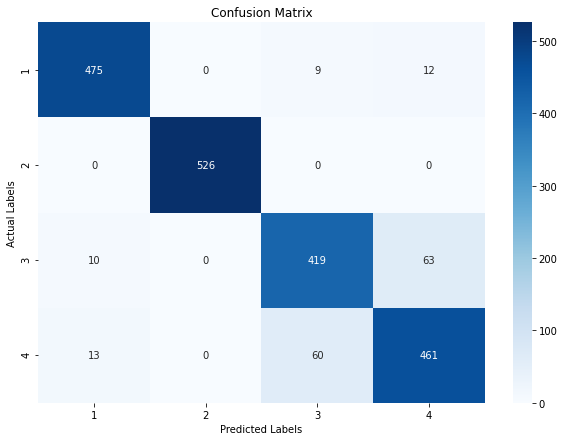

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

# Assuming val_data and val_labels are your validation datasets
predictions = custom_densenet_model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [24]:
custom_densenet_model.save('densenet_model.h5', save_format='h5')  

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(test_labels, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=CLASSES)
print(report)

                  precision    recall  f1-score   support

     NonDemented       0.95      0.96      0.96       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.89      0.86      0.87       662
ModerateDemented       0.84      0.87      0.86       624

        accuracy                           0.92      2560
       macro avg       0.92      0.92      0.92      2560
    weighted avg       0.92      0.92      0.92      2560



  0%|          | 0/1000 [00:00<?, ?it/s]

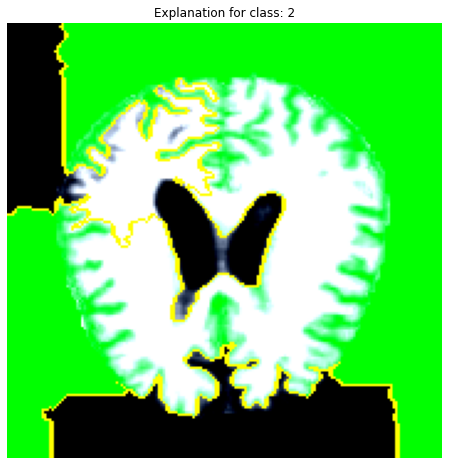

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


def preprocess_image(img_path, target_size=(176, 176)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

image_path =r"D:\test\VeryMildDemented\27 (11).jpg"
preprocessed_img = preprocess_image(image_path)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(preprocessed_img[0].astype('double'), 
                                         model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f'Explanation for class: {explanation.top_labels[0]}')
plt.axis('off') 
plt.show()
